In [1]:
# papermill parameters
zona = 37
ruta = "/Volumes/Juanjo_4TB/Disco_4T/Master_Inteligencia_Artificial/Curso_2024_25/01_Python_para_Inteligencia_Artificial/Estudio/TFM"


In [2]:
# Parameters
zona = 31
ruta = "/Volumes/Juanjo_4TB/Disco_4T/Master_Inteligencia_Artificial/Curso_2024_25/01_Python_para_Inteligencia_Artificial/Estudio/TFM"


### IMPORTA LAS LIBRERÍAS

In [3]:

import sys
import os

# Añadir la carpeta raíz del proyecto al sys.path
sys.path.append(os.path.abspath(".."))


import pandas as pd
import numpy as np

import importlib
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

import jenkspy
from sklearn.cluster import KMeans
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import src.utilidades as uti
import src.graficos as gra
import src.parametros_sismicos as par

importlib.reload(uti)
importlib.reload(par)
importlib.reload(gra)

<module 'src.graficos' from '/Volumes/Juanjo_4TB/Disco_4T/Master_Inteligencia_Artificial/Curso_2024_25/01_Python_para_Inteligencia_Artificial/Estudio/TFM/src/graficos.py'>

### LECTURA DE DATAFRAME

In [4]:

# Leer el DataFrame guardado

filename = f"datos_zona_{zona}.pkl"
output_file=ruta+"/pkl_files/"+filename

gdf_in_out = pd.read_pickle(output_file)

gdf_in_out.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1930 entries, 20306 to 141437
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Evento        1930 non-null   object        
 1   Latitud       1930 non-null   float64       
 2   Longitud      1930 non-null   float64       
 3   Prof_Km       1930 non-null   float64       
 4   Inten         1930 non-null   object        
 5   Mag           1930 non-null   float64       
 6   Tipo_Mag      1930 non-null   Int64         
 7   Localizacion  1930 non-null   object        
 8   FechaHora     1930 non-null   datetime64[ns]
 9   Mag_mbLgL     1930 non-null   float64       
 10  geometry      1930 non-null   geometry      
 11  Zona_ID       1930 non-null   float64       
dtypes: Int64(1), datetime64[ns](1), float64(6), geometry(1), object(3)
memory usage: 197.9+ KB


### GENERACIÓN DEL VECTOR DE SALIDA

In [5]:
gdf_out = par.max_mag_next_30d_fast(gdf_in_out, fecha_col="FechaHora", mag_col="Mag_mbLgL")

gdf_out.loc[gdf_out.index[-1], "Mmax_next30d"] = gdf_out.loc[gdf_out.index[-1], "Mag_mbLgL"]

gdf_out.tail()

,Evento,Latitud,Longitud,Prof_Km,Inten,Mag,Tipo_Mag,Localizacion,FechaHora,Mag_mbLgL,geometry,Zona_ID,Mmax_next30d
1925,es2025qjuyb,39.4198,0.1724,6.0,,1.3,4,GOLFO DE VALENCIA,2025-08-22 00:10:12,1.3,POINT (0.1724 39.4198),31.0,2.5
1926,es2025qollk,39.0890,-0.6224,0.0,,1.3,4,SE SUMACÀRCER.V,2025-08-24 13:02:38,1.3,POINT (-0.6224 39.089),31.0,2.5
1927,es2025qtcgx,39.3849,-0.5741,5.0,II-III,2.5,4,NE MONTSERRAT.V,2025-08-27 02:04:36,2.5,POINT (-0.5741 39.3849),31.0,1.8
1928,es2025qtjyo,39.3917,-0.5945,9.0,II,1.8,4,N MONTSERRAT.V,2025-08-27 05:57:20,1.8,POINT (-0.5945 39.3917),31.0,1.8
1929,es2025qvwup,39.4024,-0.6033,9.0,S,1.8,4,N MONTSERRAT.V,2025-08-28 14:42:40,1.8,POINT (-0.6033 39.4024),31.0,1.8


In [6]:
gdf_out.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1930 entries, 0 to 1929
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Evento        1930 non-null   object        
 1   Latitud       1930 non-null   float64       
 2   Longitud      1930 non-null   float64       
 3   Prof_Km       1930 non-null   float64       
 4   Inten         1930 non-null   object        
 5   Mag           1930 non-null   float64       
 6   Tipo_Mag      1930 non-null   Int64         
 7   Localizacion  1930 non-null   object        
 8   FechaHora     1930 non-null   datetime64[ns]
 9   Mag_mbLgL     1930 non-null   float64       
 10  geometry      1930 non-null   geometry      
 11  Zona_ID       1930 non-null   float64       
 12  Mmax_next30d  1930 non-null   float64       
dtypes: Int64(1), datetime64[ns](1), float64(7), geometry(1), object(3)
memory usage: 198.0+ KB


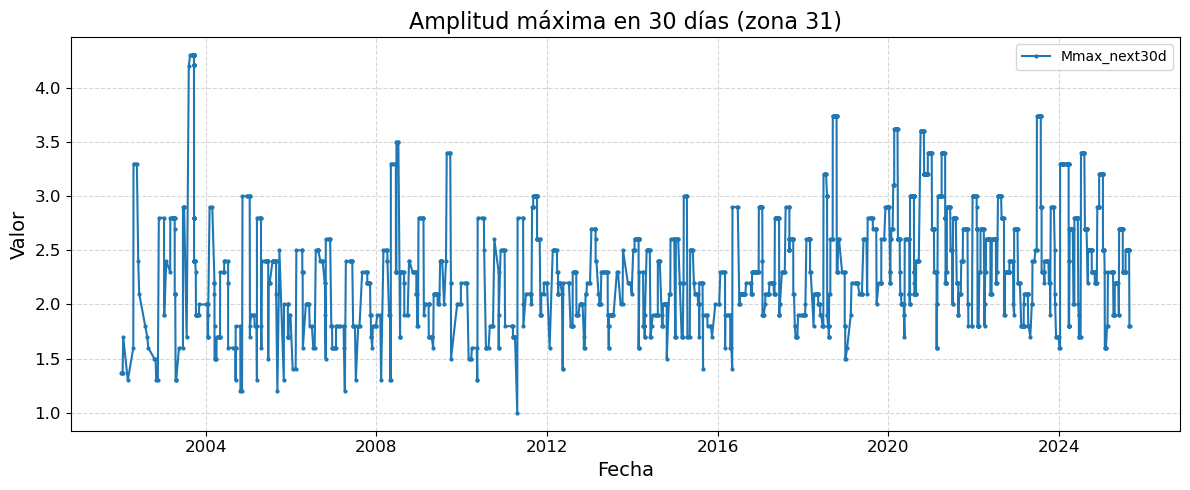

In [7]:
# Comparar evolución de la salida

filename = f"Amplitud máxima en 30 días (zona {zona})"
output_file=ruta+"/figuras/"+filename

gra.plot_evolucion_multi(
   gdf_out, 
   fecha_col="FechaHora", 
   param_cols=["Mmax_next30d"], 
   output_file=output_file,
   titulo=filename
   
)


### EVALUA DIFERENTES MÉTODOS EN FUNCIÓN DE DIFERENTES MÉTRICAS

Guarda las imágenes en pdf y png

**MÉTODOS**

•	Jenks Natural Breaks

•	Igual intervalo (Equal Interval)

•	Cuartiles (Quantiles)

•	k-means

**MÉTRICAS**

•	Entropía de Shannon

•	Información mutua

•	Bondad de ajuste de la varianza

•	Relación de varianza intraclase/interclase

•	Estadístico gap

In [8]:


# ================= FUNCIONES AUXILIARES =================

def _entropy_shannon_from_counts(counts, base=2):
    probs = counts[counts > 0] / counts.sum()
    return entropy(probs, base=base)

def _mutual_info_from_values_classes(values, classes, n_quantiles=10):
    vals = np.asarray(values)
    finite = np.isfinite(vals)
    if finite.sum() == 0:
        return np.nan
    try:
        bins = np.unique(np.percentile(vals[finite], np.linspace(0,100, n_quantiles+1)))
        if len(bins) <= 2:
            vals_disc = np.digitize(vals, np.linspace(np.nanmin(vals), np.nanmax(vals), n_quantiles+1)[1:-1])
        else:
            vals_disc = np.digitize(vals, bins[1:-1])
    except Exception:
        vals_disc = np.digitize(vals, np.linspace(np.nanmin(vals), np.nanmax(vals), n_quantiles+1)[1:-1])
    mask = np.isfinite(vals) & np.isfinite(classes)
    if mask.sum() == 0:
        return np.nan
    return mutual_info_score(vals_disc[mask], classes[mask])

def _compute_wcv_bcv(values, classes):
    vals = np.asarray(values)
    mask = np.isfinite(vals) & np.isfinite(classes)
    if mask.sum() == 0:
        return np.nan, np.nan
    vals = vals[mask]
    classes = np.asarray(classes)[mask]
    grand_mean = vals.mean()
    WCV, BCV = 0.0, 0.0
    for u in np.unique(classes):
        cluster_vals = vals[classes == u]
        if cluster_vals.size == 0:
            continue
        m = cluster_vals.mean()
        WCV += np.sum((cluster_vals - m)**2)
        BCV += cluster_vals.size * (m - grand_mean)**2
    return WCV, BCV

def _gvf_from_wcv_sst(values, wcv):
    vals = np.asarray(values)
    mask = np.isfinite(vals)
    if mask.sum() == 0:
        return np.nan
    SST = np.sum((vals[mask] - np.nanmean(vals[mask]))**2)
    if SST == 0:
        return np.nan
    return (SST - wcv) / SST

def _gap_statistic(values, classes, B=20, random_state=0):
    vals = np.asarray(values)
    mask = np.isfinite(vals) & np.isfinite(classes)
    if mask.sum() == 0:
        return np.nan
    vals = vals[mask]
    classes = np.asarray(classes)[mask]
    unique = np.unique(classes)
    Wk = 0.0
    for u in unique:
        cluster_vals = vals[classes == u]
        if cluster_vals.size == 0:
            continue
        mu = cluster_vals.mean()
        Wk += np.sum((cluster_vals - mu)**2)
    if Wk <= 0:
        return np.nan
    rng = np.random.RandomState(random_state)
    mins, maxs = vals.min(), vals.max()
    logW_refs = []
    for b in range(B):
        ref = rng.uniform(mins, maxs, size=vals.size)
        start, Wk_ref = 0, 0.0
        for u in unique:
            n_u = np.sum(classes == u)
            if n_u == 0:
                continue
            part = ref[start:start+n_u]
            mu_ref = part.mean()
            Wk_ref += np.sum((part - mu_ref)**2)
            start += n_u
        if Wk_ref > 0:
            logW_refs.append(np.log(Wk_ref))
    if len(logW_refs) == 0:
        return np.nan
    return np.mean(logW_refs) - np.log(Wk)

# ---- FUNCIÓN PARA CREAR CLASES ----
def _assign_classes(df, col_val, method, n_classes):
    """
    Devuelve etiquetas (array) e intervalos [(low, high), ...]
    Acepta métodos en inglés o en español:
    - "jenks" / "Jenks"
    - "equal" / "Igual intervalo"
    - "quantiles" / "Cuartiles"
    - "kmeans" / "K-means"
    """
    vals_all = df[col_val].values
    mask = np.isfinite(vals_all)
    labels = np.full(vals_all.shape, np.nan)
    intervals = []

    if mask.sum() == 0:
        return labels, intervals

    vals = vals_all[mask]

    # Mapeo español-inglés
    method_map = {
        "jenks": "jenks", "Jenks": "jenks",
        "equal": "equal", "Igual intervalo": "equal",
        "quantiles": "quantiles", "Cuartiles": "quantiles",
        "kmeans": "kmeans", "K-means": "kmeans"
    }
    if method not in method_map:
        raise ValueError(f"Método desconocido: {method}")
    method_std = method_map[method]

    if method_std == "jenks":
        cuts = jenkspy.jenks_breaks(vals, n_classes=n_classes)
        lbls = np.digitize(vals, cuts[1:-1], right=True) + 1
        labels[mask] = lbls
        intervals = [(cuts[i], cuts[i+1]) for i in range(len(cuts)-1)]

    elif method_std == "equal":
        bins = np.linspace(vals.min(), vals.max(), n_classes+1)
        lbls = np.digitize(vals, bins[1:-1], right=True) + 1
        labels[mask] = lbls
        intervals = [(bins[i], bins[i+1]) for i in range(len(bins)-1)]

    elif method_std == "quantiles":
        qt_edges = np.unique(np.percentile(vals, np.linspace(0,100,n_classes+1)))
        if len(qt_edges) <= 1:
            bins = np.linspace(vals.min(), vals.max(), n_classes+1)
            lbls = np.digitize(vals, bins[1:-1], right=True) + 1
            intervals = [(bins[i], bins[i+1]) for i in range(len(bins)-1)]
        else:
            lbls = np.digitize(vals, qt_edges[1:-1], right=True) + 1
            intervals = [(qt_edges[i], qt_edges[i+1]) for i in range(len(qt_edges)-1)]
        labels[mask] = lbls

    elif method_std == "kmeans":
        kmeans = KMeans(n_clusters=n_classes, random_state=0).fit(vals.reshape(-1,1))
        lbls = kmeans.labels_ + 1
        labels[mask] = lbls
        for k in range(1, n_classes+1):
            cluster_vals = vals[lbls == (k-1)]
            if cluster_vals.size == 0:
                intervals.append((np.nan, np.nan))
            else:
                intervals.append((cluster_vals.min(), cluster_vals.max()))

    return labels, intervals



In [9]:
def evaluate_classification_methods_v3(df, col_val="Mmax_next30d",
                                       n_min=2, n_max=10,
                                       gap_B=20,
                                       umbral_codo=0.1,
                                       out_prefix="classification_eval",
                                       figsize=(8, 4*5)):
    methods = ["Jenks", "Igual intervalo", "Cuartiles", "K-means"]
    rows = []

    # -------- Evaluación --------
    for method in methods:
        for n in range(n_min, n_max+1):
            try:
                labels, intervals = _assign_classes(df, col_val, method, n)
            except Exception as e:
                print(f"[ERROR] Método={method}, n_classes={n}: {e}")
                rows.append({ "method": method, "n_classes": n,
                              "entropy": np.nan, "mutual_info": np.nan,
                              "GVF": np.nan, "WCV_div_BCV": np.nan, "gap": np.nan })
                continue

            labels_arr = np.array(labels, dtype=float)
            finite_mask = np.isfinite(labels_arr)
            if finite_mask.sum() == 0:
                entropy_v = mi = gvf = wcv_div_bcv = gap = np.nan
            else:
                counts = np.bincount(labels_arr[finite_mask].astype(int))
                entropy_v = _entropy_shannon_from_counts(counts)
                mi = _mutual_info_from_values_classes(df[col_val].values, labels_arr)
                wcv, bcv = _compute_wcv_bcv(df[col_val].values, labels_arr)
                wcv_div_bcv = wcv/bcv if bcv>0 else np.nan
                gvf = _gvf_from_wcv_sst(df[col_val].values, wcv)
                gap = _gap_statistic(df[col_val].values, labels_arr, B=gap_B)

            rows.append({"method": method, "n_classes": n,
                         "entropy": entropy_v, "mutual_info": mi,
                         "GVF": gvf, "WCV_div_BCV": wcv_div_bcv, "gap": gap})

    results_df = pd.DataFrame(rows)

    # -------- Detectar codos --------
    metrics_plot = [
        ("entropy", "Entropía de Shannon"),
        ("mutual_info", "Información Mutua"),
        ("GVF", "Bondad de ajuste de la varianza (GVF)"),
        ("WCV_div_BCV", "Relación WCV / BCV"),
        ("gap", "Estadístico gap")
    ]
    optimal_classes = {m:{} for m in methods}
    color_map = {"Jenks":"C0","Igual intervalo":"C1","Cuartiles":"C2","K-means":"C3"}
    jitter = {"Jenks": -0.08, "Igual intervalo": -0.04, "Cuartiles": 0.04, "K-means": 0.08}

    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=figsize, sharex=True)
    for ax, (metric_key, metric_label) in zip(axes, metrics_plot):
        for method in methods:
            sub = results_df[results_df["method"]==method]
            x = sub["n_classes"].values
            y = sub[metric_key].values
            ax.plot(x, y, marker="o", color=color_map[method], label=method)

            y = np.array(y); x = np.array(x)
            n_opt = x[-1]
            for i in range(1,len(y)):
                mejora = (y[i]-y[i-1])/max(abs(y[i-1]),1e-12)
                if metric_key=="WCV_div_BCV":
                    mejora = -mejora
                if mejora < umbral_codo:
                    n_opt = x[i]; break
            optimal_classes[method][metric_key] = n_opt
            ax.axvline(n_opt + jitter[method], color=color_map[method], linestyle="--", alpha=0.7)

        ax.set_ylabel(metric_label, fontsize=14)
        ax.set_title(metric_label, fontsize=16)
        ax.tick_params(axis="both", labelsize=12)
        ax.grid(alpha=0.3)
        ax.legend(fontsize=10)
    axes[-1].set_xlabel("Número de clases", fontsize=14)
    plt.tight_layout()

    # Guardar
    fig.savefig(f"{out_prefix}.pdf", bbox_inches="tight")
    fig.savefig(f"{out_prefix}.png", bbox_inches="tight", dpi=300)

    # Mostrar
    plt.show()

    # -------- Tabla de clases --------
    def get_class_table(method, n_classes):
        labels, intervals = _assign_classes(df, col_val, method, n_classes)
        labels_arr = np.array(labels, dtype=float)
        rows_tab = []
        for i in range(1, n_classes+1):
            try:
                low, high = intervals[i-1]
            except:
                low, high = (np.nan,np.nan)
            count = int(np.sum(labels_arr==i))
            rows_tab.append({"class_index":i,
                             "Intervalo_magnitudes": f"{low:.3f} - {high:.3f}" if np.isfinite(low) and np.isfinite(high) else "nan",
                             "Num_terremotos": count})
        return pd.DataFrame(rows_tab)

    return {"results_df":results_df,
            "optimal_classes":optimal_classes,
            "get_class_table":get_class_table,
            "plot_pdf":f"{out_prefix}.pdf",
            "plot_png":f"{out_prefix}.png"}


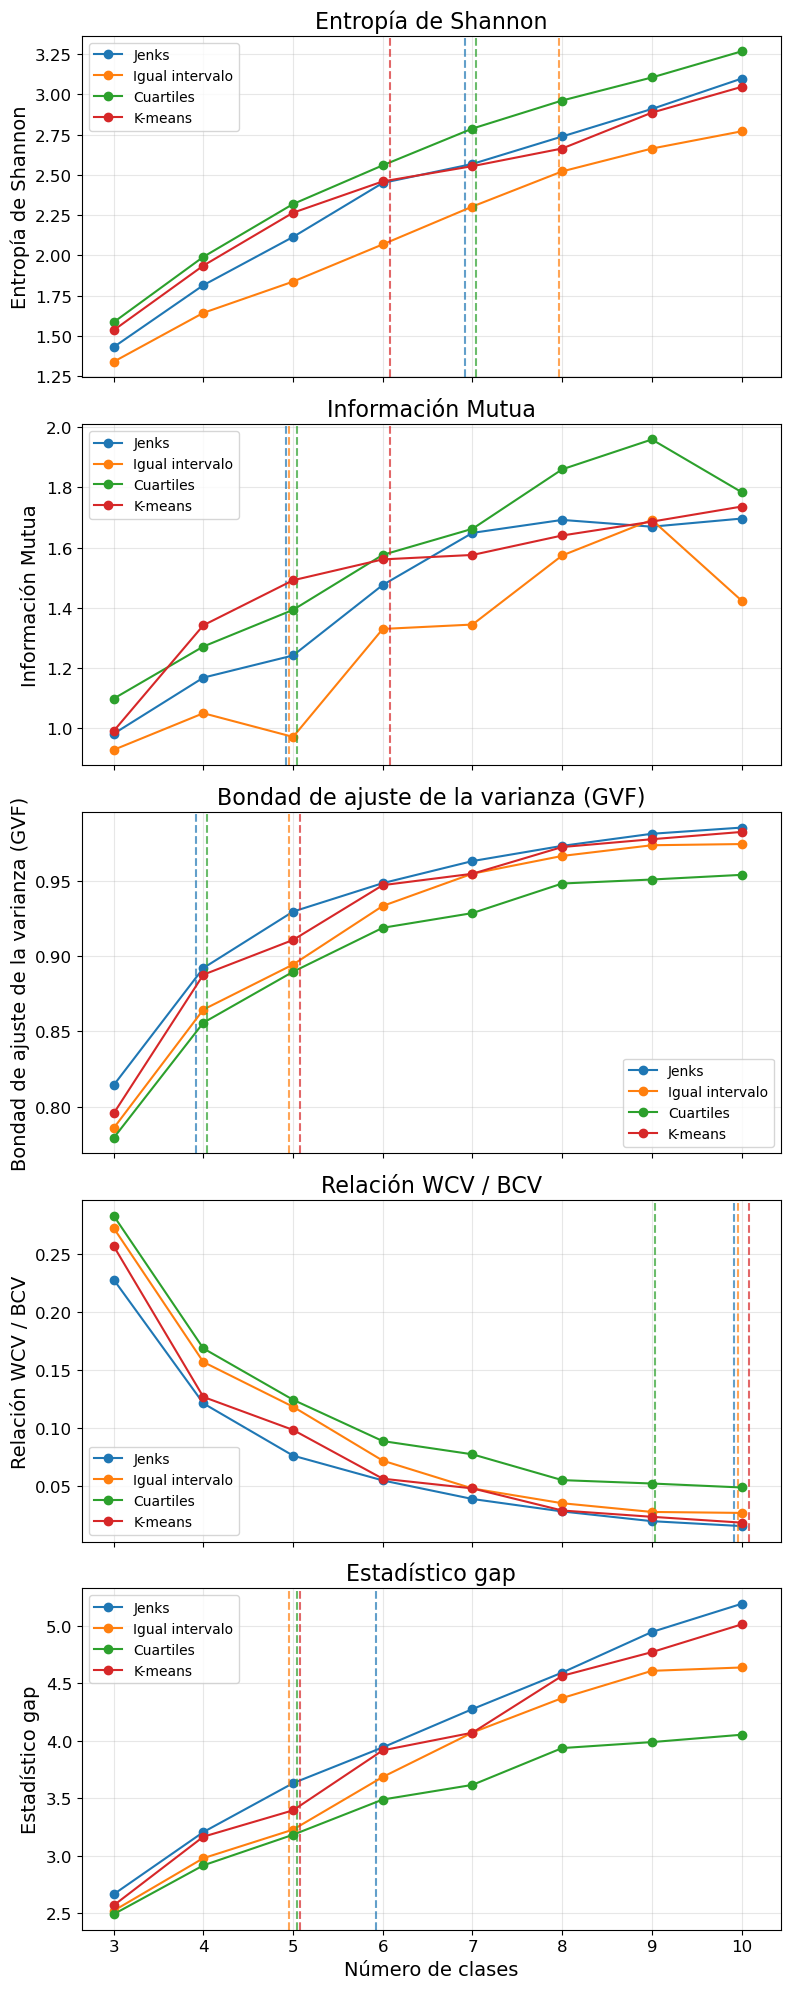

In [10]:

filename = f"metodos_clasificacion_salida_zona_{zona}"
output_file=ruta+"/figuras/"+filename

# Ejecutar evaluación de métodos de clasificación
res = evaluate_classification_methods_v3(
    df=gdf_out,
    col_val="Mmax_next30d",  # columna a clasificar
    n_min=3,                 # número mínimo de clases
    n_max=10,                # número máximo de clases
    gap_B=30,                # número de simulaciones para el gap statistic
    out_prefix=output_file,  # nombre base para guardar gráficos
    umbral_codo=0.10         # umbral del codo en 10%
)

### EXTRAE LAS CLASES ÓPTIMAS PARA LA MÉTRICA CUARTILES Y JENKS

In [11]:
# Extraer óptimos solo para enks
optimos_cuartiles = res["optimal_classes"]["Cuartiles"]

# Pasar a tabla
tabla_optimos_cuartiles = pd.DataFrame([
    {"Métrica": metrica, "Clases óptimas": n_opt}
    for metrica, n_opt in optimos_cuartiles.items()
])

print("Métrica: Cuartiles")
print(tabla_optimos_cuartiles)
print("\n")

# Extraer óptimos solo para enks
optimos_jenks = res["optimal_classes"]["Jenks"]

# Pasar a tabla
tabla_optimos_jenks = pd.DataFrame([
    {"Métrica": metrica, "Clases óptimas": n_opt}
    for metrica, n_opt in optimos_jenks.items()
])



Métrica: Cuartiles
       Métrica  Clases óptimas
0      entropy               7
1  mutual_info               5
2          GVF               4
3  WCV_div_BCV               9
4          gap               5




### INTERVALOS DE MAGNITUDES Y NÚMERO DE TERREMOTOS

In [12]:

# Obtener tabla de intervalos y número de terremotos para Cuartiles con 4 clases
tabla_cuartiles_5 = res["get_class_table"]("Cuartiles", 4)

print("Métrica: Cuartiles")
print(tabla_cuartiles_5)
print("\n")

# obtener tabla de intervalos y número de terremotos para Jenks con 4 clases
tabla_jenks_5 = res["get_class_table"]("Jenks", 4)

print("Métrica: Jenks")
print(tabla_jenks_5)


Métrica: Cuartiles
   class_index Intervalo_magnitudes  Num_terremotos
0            1        1.000 - 2.000             524
1            2        2.000 - 2.300             444
2            3        2.300 - 2.800             547
3            4        2.800 - 4.300             415


Métrica: Jenks
   class_index Intervalo_magnitudes  Num_terremotos
0            1        1.000 - 2.000             524
1            2        2.000 - 2.600             787
2            3        2.600 - 3.300             476
3            4        3.300 - 4.300             143


### VALORES MEDIOS, DESVIACIÓN ESTÁNDAR Y DIFERENCIA MÁX-MIN DEL NUMERO DE EVENTOS EN LAS CLASES

In [13]:

# Métrica: Cuartiles

# Extraer la columna de números de terremotos
counts_cuartiles = tabla_cuartiles_5["Num_terremotos"].values

# Calcular media y desviación estándar
mean_counts_cuartiles = np.mean(counts_cuartiles)
std_counts_cuartiles = np.std(counts_cuartiles, ddof=1)  # ddof=1 para desviación estándar muestral

max_counts_cuartiles = np.max(counts_cuartiles)
min_counts_cuartiles = np.min(counts_cuartiles)
dif_counts_cuartiles=max_counts_cuartiles-min_counts_cuartiles

print("Métrica: Cuartiles")
print(f"Media de terremotos por clase: {mean_counts_cuartiles:.2f}")
print(f"Desviación estándar: {std_counts_cuartiles:.2f}")
print(f"Diferencia máximo - mínimo: {dif_counts_cuartiles:.2f}")
print("\n")

# Métrica: Jenks

# Extraer la columna de números de terremotos
counts_jenks = tabla_jenks_5["Num_terremotos"].values

# Calcular media y desviación estándar
mean_counts_jenks = np.mean(counts_jenks)
std_counts_jenks = np.std(counts_jenks, ddof=1)  # ddof=1 para desviación estándar muestral

max_counts_jenks = np.max(counts_jenks)
min_counts_jenks = np.min(counts_jenks)
dif_counts_jenks=max_counts_jenks-min_counts_jenks

print("Métrica: Jenks")
print(f"Media de terremotos por clase: {mean_counts_jenks:.2f}")
print(f"Desviación estándar: {std_counts_jenks:.2f}")
print(f"Diferencia máximo - mínimo: {dif_counts_jenks:.2f}")

Métrica: Cuartiles
Media de terremotos por clase: 482.50
Desviación estándar: 63.04
Diferencia máximo - mínimo: 132.00


Métrica: Jenks
Media de terremotos por clase: 482.50
Desviación estándar: 264.41
Diferencia máximo - mínimo: 644.00


### REPRESENTACIÓN GRÁFICA DE LOS INTERVALOS PARA UNA METODOLOGÍA Y NÚMERO DE CLASES DADO.

In [14]:

def plot_class_distributions(res, method="jenks", n_classes_list=[4,5,6], figsize=(5*3,5),
                             out_prefix=None):
    """
    Muestra diagramas de barras de la distribución de terremotos por clase
    para un método y varios números de clases.

    Parámetros:
    -----------
    res : dict
        Resultado de evaluate_classification_methods_v3
    method : str
        Método de clasificación ("jenks","equal","quantiles","kmeans")
    n_classes_list : list[int]
        Lista de números de clases a mostrar
    figsize : tuple
        Tamaño de la figura (ancho, alto)
    out_prefix : str or None
        Nombre base para guardar PDF/PNG. Si None, no guarda.
    """
    n_cols = len(n_classes_list)
    fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=figsize, sharey=True)

    if n_cols == 1:
        axes = [axes]  # para mantener iterable

    colors = {"Jenks":"C0","Igual intervalo":"C1","Cuartiles":"C2","K-means":"C3"}

    for ax, n_classes in zip(axes, n_classes_list):
        table_df = res["get_class_table"](method=method, n_classes=n_classes)
        if table_df.empty:
            continue

        intervals = []
        counts = []
        for _, row in table_df.iterrows():
            interval = row["Intervalo_magnitudes"]
            if " - " in interval:
                try:
                    low, high = [float(v) for v in interval.split(" - ")]
                    intervals.append((low, high))
                    counts.append(row["Num_terremotos"])
                except:
                    continue

        if not intervals:
            continue

        x_ticks = np.array([ (low+high)/2 for low, high in intervals ])
        heights = np.array(counts)
        width = np.array([high-low for low, high in intervals]) * 0.8

        ax.bar(x_ticks, heights, width=width, color=colors.get(method,"C0"), alpha=0.7)
        ax.set_title(f"{method.capitalize()} - {n_classes} clases", fontsize=16)
        ax.set_xlabel("Magnitud", fontsize=14)
        ax.tick_params(axis='both', labelsize=12)
        ax.grid(alpha=0.3)

    axes[0].set_ylabel("Número de terremotos", fontsize=14)
    plt.tight_layout()

    if out_prefix:
        fig.savefig(f"{out_prefix}.pdf", bbox_inches='tight')
        fig.savefig(f"{out_prefix}.png", bbox_inches='tight', dpi=300)

    plt.show()


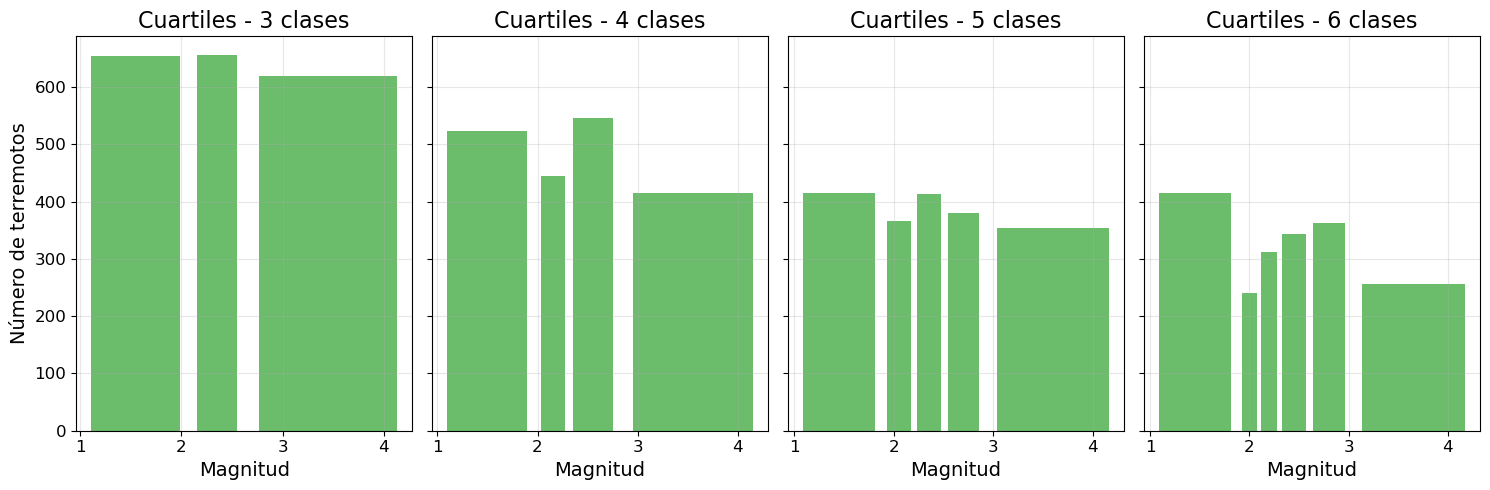

In [15]:

# Métrica: Cuartiles

filename = f"Cuartiles_3_4_5_6_clases_zona_{zona}"
output_file=ruta+"/figuras/"+filename

# Mostrar diagramas para Cuartiles con 3, 4, 5 y 6 clases y guardar la figura
plot_class_distributions(res, method="Cuartiles", n_classes_list=[3,4,5,6],
                         out_prefix=output_file)


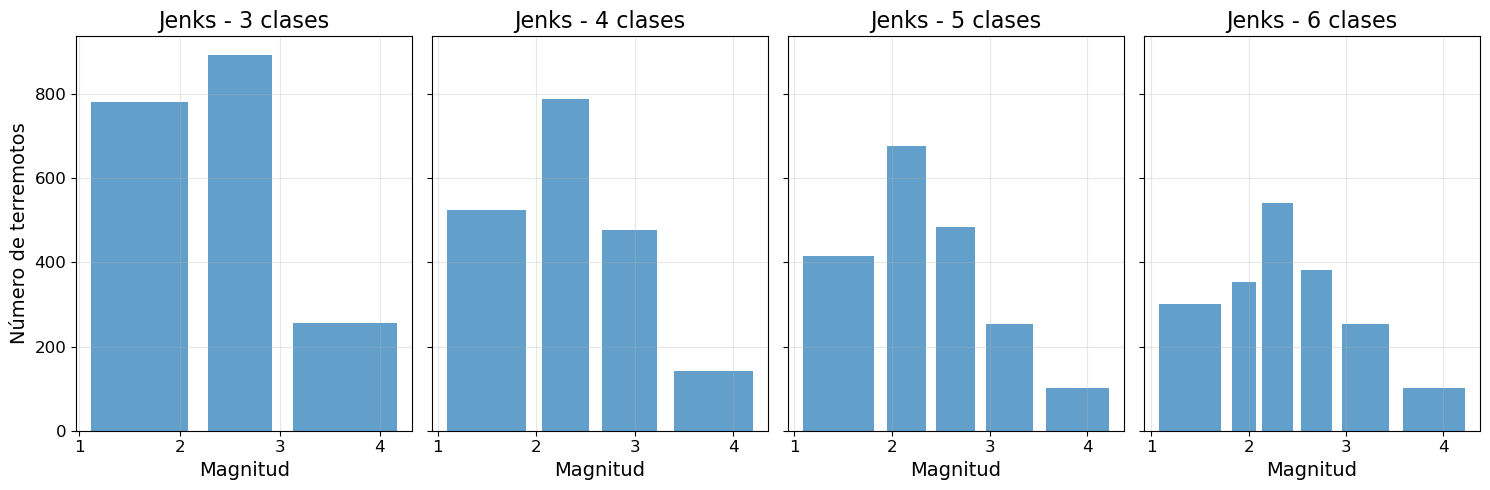

In [16]:
# Métrica: Jenks

filename = f"Jenks_3_4_5_6_clases_zona_{zona}"
output_file=ruta+"/figuras/"+filename

# Mostrar diagramas para Jenks con 3, 4, 5 y 6 clases y guardar la figura
plot_class_distributions(res, method="Jenks", n_classes_list=[3,4,5,6],
                         out_prefix=output_file)

### ACTUALIZACIÓN DEL DATAFRAME CON EL VECTOR DE CLASES DE SALIDA

In [17]:
def asignar_clases_transformer(
    df, res, metodo="Jenks", n_classes=4,
    col_val="Mmax_next30d", class_label="class_label"
):
    """
    Asigna clases a cada fila del dataframe según el método y número de clases elegido.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame original con la columna a clasificar.
    res : dict
        Resultado de evaluate_classification_methods_v3 (con get_class_table).
    metodo : str
        Método de clasificación a usar. Ej: "Jenks", "Cuartiles", "Igual intervalo", "K-means".
    n_classes : int
        Número de clases.
    col_val : str
        Nombre de la columna con el valor numérico a clasificar (ej. magnitud).
    class_label : str
        Nombre de la columna de las clases.

    Retorna
    -------
    df_out : pd.DataFrame
        Copia de df con nueva columna `class_label` que contiene el índice de clase asignado.
    """
    import numpy as np
    import pandas as pd

    # Obtener tabla de intervalos del resultado res
    tabla = res["get_class_table"](metodo, n_classes)

    # Crear copia del dataframe
    df_out = df.copy()
    df_out[class_label] = np.nan

    # Asignar clases según intervalos intermedios
    for i, row in tabla.iterrows():
        low, high = map(float, row["Intervalo_magnitudes"].split(" - "))
        mask = (df_out[col_val] >= low) & (df_out[col_val] < high)
        df_out.loc[mask, class_label] = row["class_index"] - 1  # empezamos en 0 para ML

    # Manejo especial del último intervalo (incluye extremo superior)
    low, high = map(float, tabla.iloc[-1]["Intervalo_magnitudes"].split(" - "))
    mask = (df_out[col_val] >= low) & (df_out[col_val] <= high)
    df_out.loc[mask, class_label] = tabla.iloc[-1]["class_index"] - 1

    # --- Asignación de valores fuera de rango ---
    min_low = float(tabla.iloc[0]["Intervalo_magnitudes"].split(" - ")[0])
    max_high = float(tabla.iloc[-1]["Intervalo_magnitudes"].split(" - ")[1])

    # Valores menores al límite inferior → clase más baja
    df_out.loc[df_out[col_val] < min_low, class_label] = 0

    # Valores mayores al límite superior → clase más alta
    df_out.loc[df_out[col_val] > max_high, class_label] = n_classes - 1

    # Convertir a enteros
    df_out[class_label] = df_out[class_label].astype(int)

    return df_out


In [18]:

# Métrica: Cuartiles

df_out_cuartiles = asignar_clases_transformer(
    df=gdf_out,
    res=res,
    metodo="Cuartiles",
    n_classes=4,
    col_val="Mmax_next30d",
    class_label="Class_label_Cuartiles"
)

print("Métrica: Cuartiles")
print(df_out_cuartiles[["Mmax_next30d", "Class_label_Cuartiles"]].tail())
print("\n")

# Métrica: Jenks

df_out = asignar_clases_transformer(
    df=df_out_cuartiles,
    res=res,
    metodo="Jenks",
    n_classes=4,
    col_val="Mmax_next30d",
    class_label="Class_label_Jenks"
)

print("Métrica: Jenks")
print(df_out[["Mmax_next30d", "Class_label_Jenks"]].tail())


Métrica: Cuartiles
      Mmax_next30d  Class_label_Cuartiles
1925           2.5                      2
1926           2.5                      2
1927           1.8                      0
1928           1.8                      0
1929           1.8                      0


Métrica: Jenks
      Mmax_next30d  Class_label_Jenks
1925           2.5                  1
1926           2.5                  1
1927           1.8                  0
1928           1.8                  0
1929           1.8                  0


### GUARDA EL NUEVO DATAFRAME

In [19]:
filename = f"Datos_salida_clases_zona_{zona}.pkl"
output_file=ruta+"/pkl_files/"+filename

df_out.to_pickle(output_file)

print(f"Guardado {filename} con {len(df_out)} filas")



Guardado Datos_salida_clases_zona_31.pkl con 1930 filas
